In [16]:
import json
import random

def generate_supplier_graph(num_companies=6):
    assert num_companies <= 6, "Maximum of 6 companies allowed"

    companies = [f"COMP{i:03d}" for i in range(1, num_companies + 1)]
    root_supplier = companies[-1]  # last company is the root supplier

    graph = {}

    for company in companies:
        # Random weights for each company
        weights = {
            "societal": round(random.uniform(70, 100), 2),
            "economic": round(random.uniform(5000, 10000), 2),
            "global": round(random.uniform(2000, 5000), 2)
        }

        # Dependencies (edges)
        edges = {}
        if company != root_supplier:
            possible_suppliers = [c for c in companies if c != company and companies.index(c) > companies.index(company)]
            # Each company depends on 1–3 suppliers (that appear later in the list)
            suppliers = random.sample(possible_suppliers, k=min(len(possible_suppliers), random.randint(1, 3)))
            for supplier in suppliers:
                edges[supplier] = round(random.uniform(0.2, 0.4), 3)

        graph[company] = {"weights": weights, "edges": edges}

    return graph


# Generate and print example JSON
graph_data = generate_supplier_graph(6)
print(json.dumps(graph_data, indent=2))

{
  "COMP001": {
    "weights": {
      "societal": 80.28,
      "economic": 5347.09,
      "global": 4899.37
    },
    "edges": {
      "COMP002": 0.323,
      "COMP003": 0.28,
      "COMP006": 0.315
    }
  },
  "COMP002": {
    "weights": {
      "societal": 75.0,
      "economic": 7554.6,
      "global": 2146.97
    },
    "edges": {
      "COMP004": 0.363
    }
  },
  "COMP003": {
    "weights": {
      "societal": 72.67,
      "economic": 9994.3,
      "global": 3415.6
    },
    "edges": {
      "COMP004": 0.225,
      "COMP005": 0.295,
      "COMP006": 0.331
    }
  },
  "COMP004": {
    "weights": {
      "societal": 77.15,
      "economic": 9356.05,
      "global": 3989.02
    },
    "edges": {
      "COMP006": 0.295,
      "COMP005": 0.35
    }
  },
  "COMP005": {
    "weights": {
      "societal": 74.76,
      "economic": 6111.83,
      "global": 3369.99
    },
    "edges": {
      "COMP006": 0.242
    }
  },
  "COMP006": {
    "weights": {
      "societal": 92.31,
      "

In [17]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, Any, List


class GraphAnalyzerCIDM:
    """
    Executive Summary:
    -------------------
    This class provides a framework for analyzing inter-company dependencies
    in a critical infrastructure or digital supply-chain network.
    
    Each node represents a company (or service provider).
    Each directed edge represents an operational dependency (A → B means A relies on B).
    Edge weights represent reliance intensity (0–1), while node weights reflect
    each company's intrinsic importance to the economy or society.
    
    This system helps regulators or analysts identify:
      • Hidden but critical providers.
      • Systemic dependencies and cascade risks.
      • Potential regulatory supervision targets.
    """

    def __init__(self, graph_file: str) -> None:
        """Initialize the CIDM graph from a JSON file."""
        self.graph_file: str = graph_file
        self.G: nx.DiGraph = nx.DiGraph()
        self.load_graph()

    # CORE FUNCTIONALITY
    def load_graph(self) -> None:
        """Load graph data from a JSON file and construct a directed graph."""
        with open(self.graph_file, "r") as f:
            graph_data: Dict[str, Any] = json.load(f)

        # Add nodes (companies) with intrinsic weights
        for node_id, node_data in graph_data.items():
            self.G.add_node(node_id, **node_data["weights"])

        # Add edges (dependencies) with reliance weights
        for node_id, node_data in graph_data.items():
            for target_id, edge_weight in node_data["edges"].items():
                self.G.add_edge(node_id, target_id, weight=edge_weight)

    def summary(self) -> None:
        """Print an executive snapshot of the graph’s scale and structure."""
        print("=== CIDM NETWORK SUMMARY ===")
        print(f"Nodes (Companies): {self.G.number_of_nodes()}")
        print(f"Edges (Dependencies): {self.G.number_of_edges()}")

        node_attrs = list(self.G.nodes(data=True))[:5]
        edge_attrs = list(self.G.edges(data=True))[:5]

        print("\nSample Nodes (Top 5):", node_attrs)
        print("Sample Edges (Top 5):", edge_attrs)
        print("============================\n")

    # VISUALIZATION
    def visualize(
        self,
        min_size: int = 100,
        max_size: int = 2000,
        edge_scale: float = 10.0,
        layout: str = "spring",
        seed: int = 42
    ) -> None:
        """
        Visualize the network to understand structure, size, and dependencies.

        Node size  = Global criticality
        Node color = Societal criticality
        Edge width = Operational reliance
        """
        globals_list: List[float] = [self.G.nodes[n]["global"] for n in self.G.nodes]
        min_val, max_val = min(globals_list), max(globals_list)
        node_sizes = [
            min_size + (val - min_val) / (max_val - min_val) * (max_size - min_size)
            for val in globals_list
        ]

        node_colors: List[float] = [self.G.nodes[n]["societal"] for n in self.G.nodes]
        edge_widths: List[float] = [self.G[u][v]["weight"] * edge_scale for u, v in self.G.edges]

        # Layout options for better readability
        if layout == "spring":
            pos = nx.spring_layout(self.G, k=0.5, seed=seed)
        elif layout == "circular":
            pos = nx.circular_layout(self.G)
        elif layout == "kamada_kawai":
            pos = nx.kamada_kawai_layout(self.G)
        else:
            raise ValueError("Unsupported layout type")

        # Draw the network
        plt.figure(figsize=(12, 12))
        nx.draw_networkx_nodes(
            self.G, pos, node_size=node_sizes, node_color=node_colors,
            cmap=plt.cm.viridis, alpha=0.8
        )
        nx.draw_networkx_edges(
            self.G, pos, width=edge_widths, alpha=0.6, arrows=True,
            arrowstyle="-|>", arrowsize=15
        )
        nx.draw_networkx_labels(self.G, pos, font_size=8, font_color="black")
        plt.title(
            "Company Dependency Graph\n"
            "Node size = Global criticality, Edge width = Operational reliance"
        )
        plt.axis("off")
        plt.show()

    # ANALYTICAL METHODS
    def systemic_influence(self, damping: float = 0.85, max_iter: int = 100, tol: float = 1e-6) -> Dict[str, float]:
        """
        Compute recursive systemic influence for all companies.
        
        Each company's score is influenced by the criticality of companies that depend on it,
        weighted by dependency strength (edge weight) and propagated recursively.

        Parameters
        ----------
        damping : float
            Damping factor (like in PageRank, 0 < damping < 1)
        max_iter : int
            Maximum number of iterations
        tol : float
            Convergence tolerance

        Returns
        -------
        Dict[str, float]
            Node ID -> systemic influence score (sorted descending)
        """
        # Initialize scores with intrinsic global importance
        scores = {node: self.G.nodes[node]["global"] for node in self.G.nodes}
        
        for iteration in range(max_iter):
            new_scores = {}
            max_change = 0.0
            
            for node in self.G.nodes:
                # Sum over all inbound edges (who depends on me)
                total = sum(
                    scores[src] * d["weight"] for src, _, d in self.G.in_edges(node, data=True)
                )
                # Update with damping: preserves intrinsic node weight
                new_score = (1 - damping) * self.G.nodes[node]["global"] + damping * total
                new_scores[node] = new_score
                max_change = max(max_change, abs(new_score - scores[node]))
            
            scores = new_scores
            
            if max_change < tol:
                break
        
        # Return scores sorted descending
        return dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))


    def systemic_importance(self) -> Dict[str, float]:
        """
        Measure: Systemic Importance Index
        ----------------------------------
        Combines dependency influence (inbound reliance)
        with intrinsic company importance (global weight).
        Identifies 'too critical to fail' nodes in the ecosystem.
        """
        dep_centrality = self.dependency_centrality()
        importance = {}
        for node in self.G.nodes:
            w_dep = dep_centrality[node]
            w_glob = self.G.nodes[node]["global"]
            importance[node] = (0.6 * w_dep) + (0.4 * w_glob)
        return dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))

    def simulate_failure_recursive(self, node: str, threshold: float = 0.3, company_file: str = "../data/company_data.json") -> List[Dict[str, str]]:
        """
        Cascading failure simulation with recursive propagation.
        Computes effective dependency along chains using multiplication of edge weights.
        """
        # Load company names
        try:
            with open(company_file, "r") as f:
                companies = json.load(f)
            id_to_name = {c["company_id"]: c["company_name"] for c in companies}
        except FileNotFoundError:
            id_to_name = {}

        failed = {node}
        # Track effective dependencies for all nodes
        effective_dep = {node: 1.0}

        changed = True
        while changed:
            changed = False
            for n in self.G.nodes:
                if n in failed:
                    continue
                # Compute max effective dependency to any failed node
                max_dep = 0.0
                for succ in self.G.successors(n):
                    if succ in effective_dep:
                        max_dep = max(max_dep, self.G[n][succ]["weight"] * effective_dep[succ])
                if max_dep >= threshold:
                    failed.add(n)
                    effective_dep[n] = max_dep
                    changed = True

        affected_list = [{"company_id": cid, "company_name": id_to_name.get(cid, "Unknown")} for cid in failed]
        return affected_list


    def get_company_info(self, company_id: str, company_file: str = "../data/company_data.json") -> dict:
        """
        Retrieve all useful information about a company given its company_id.

        Parameters
        ----------
        company_id : str
            ID of the company to retrieve.
        company_file : str
            Path to the JSON file containing company details.

        Returns
        -------
        dict
            Dictionary with all available information, or empty dict if not found.
        """
        try:
            with open(company_file, "r") as f:
                companies = json.load(f)
            for comp in companies:
                if comp.get("company_id") == company_id:
                    return comp
            print(f"Company {company_id} not found in {company_file}.")
            return {}
        except FileNotFoundError:
            print(f"File {company_file} not found.")
            return {}

=== GRAPH SUMMARY ===
=== CIDM NETWORK SUMMARY ===
Nodes (Companies): 30
Edges (Dependencies): 349

Sample Nodes (Top 5): [('COMP001', {'societal': 91.09, 'economic': 8627.86, 'global': 3932.64}), ('COMP002', {'societal': 87.81, 'economic': 16902.31, 'global': 7654.34}), ('COMP003', {'societal': 72.73, 'economic': 47460.27, 'global': 21397.12}), ('COMP004', {'societal': 34.27, 'economic': 16600.78, 'global': 7489.2}), ('COMP005', {'societal': 82.21, 'economic': 45902.79, 'global': 20701.47})]
Sample Edges (Top 5): [('COMP001', 'COMP021', {'weight': 0.224}), ('COMP001', 'COMP008', {'weight': 0.253}), ('COMP001', 'COMP024', {'weight': 0.327}), ('COMP001', 'COMP012', {'weight': 0.299}), ('COMP001', 'COMP023', {'weight': 0.24})]

=== COMPUTING SYSTEMIC INFLUENCE ===

Top 10 most systemically critical companies:
1. COMP015: 62827055019898216897122428627642673512083775029248.00
2. COMP028: 61031504395943777554115978535220160304612496113664.00
3. COMP022: 5745859387423708511887222298198880293

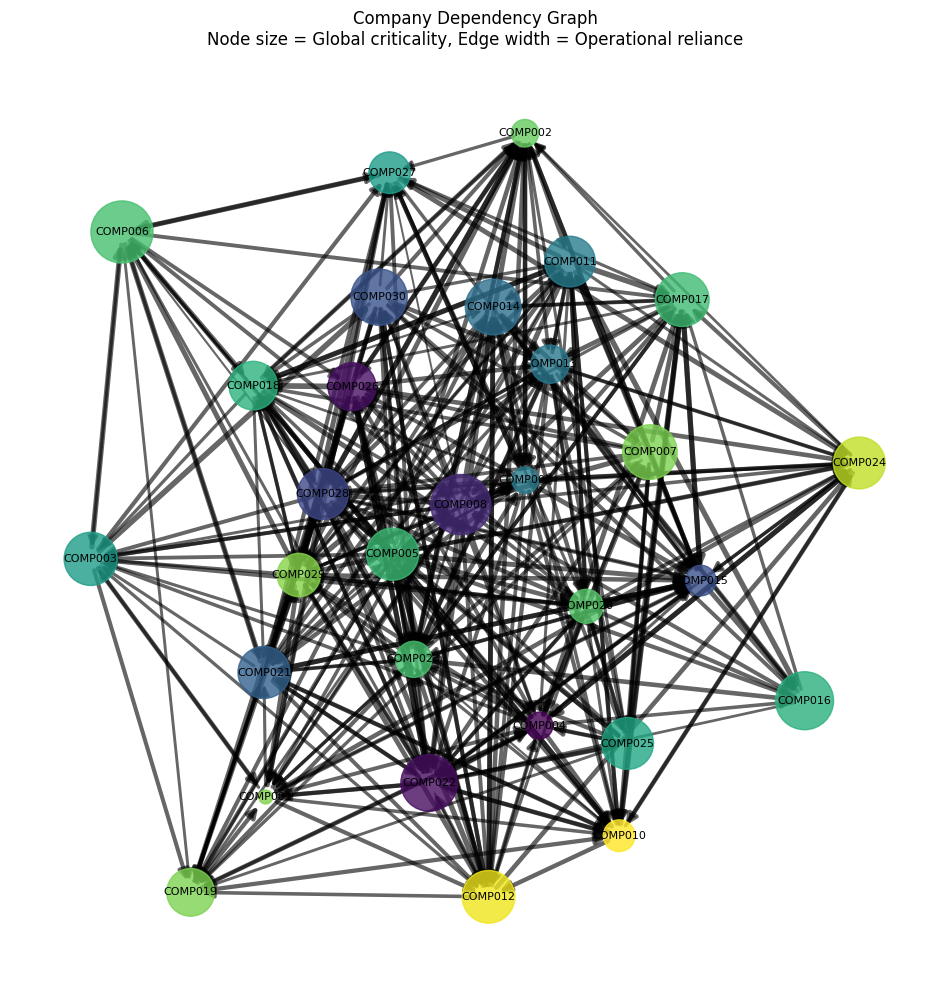

In [21]:
# TEST SCRIPT FOR CIDM
if __name__ == "__main__":
    # Initialize analyzer with your graph data
    analyzer = GraphAnalyzerCIDM("../data/graph_data.json")

    # 1️⃣ Print executive summary of the graph
    print("=== GRAPH SUMMARY ===")
    analyzer.summary()

    # 2️⃣ Compute recursive systemic influence
    print("=== COMPUTING SYSTEMIC INFLUENCE ===")
    influence_scores = analyzer.systemic_influence()

    # Print top 10 systemically critical companies
    print("\nTop 10 most systemically critical companies:")
    for i, (company, score) in enumerate(list(influence_scores.items())[:10], start=1):
        print(f"{i}. {company}: {score:.2f}")

    # 3️⃣ Optional: simulate failure of top critical company
    top_company = list(influence_scores.keys())[0]
    print(f"\nSimulating failure of {top_company}...")
    affected_companies = analyzer.simulate_failure_recursive(top_company, threshold=0.3)
    print(f"{len(affected_companies)} companies would be affected:")
    print(affected_companies)

    # 4️⃣ Optional: visualize network
    print("\nVisualizing network (this may take a moment)...")
    analyzer.visualize()

=== CIDM NETWORK SUMMARY ===
Nodes (Companies): 30
Edges (Dependencies): 349

Sample Nodes (Top 5): [('COMP001', {'societal': 91.09, 'economic': 8627.86, 'global': 3932.64}), ('COMP002', {'societal': 87.81, 'economic': 16902.31, 'global': 7654.34}), ('COMP003', {'societal': 72.73, 'economic': 47460.27, 'global': 21397.12}), ('COMP004', {'societal': 34.27, 'economic': 16600.78, 'global': 7489.2}), ('COMP005', {'societal': 82.21, 'economic': 45902.79, 'global': 20701.47})]
Sample Edges (Top 5): [('COMP001', 'COMP021', {'weight': 0.224}), ('COMP001', 'COMP008', {'weight': 0.253}), ('COMP001', 'COMP024', {'weight': 0.327}), ('COMP001', 'COMP012', {'weight': 0.299}), ('COMP001', 'COMP023', {'weight': 0.24})]



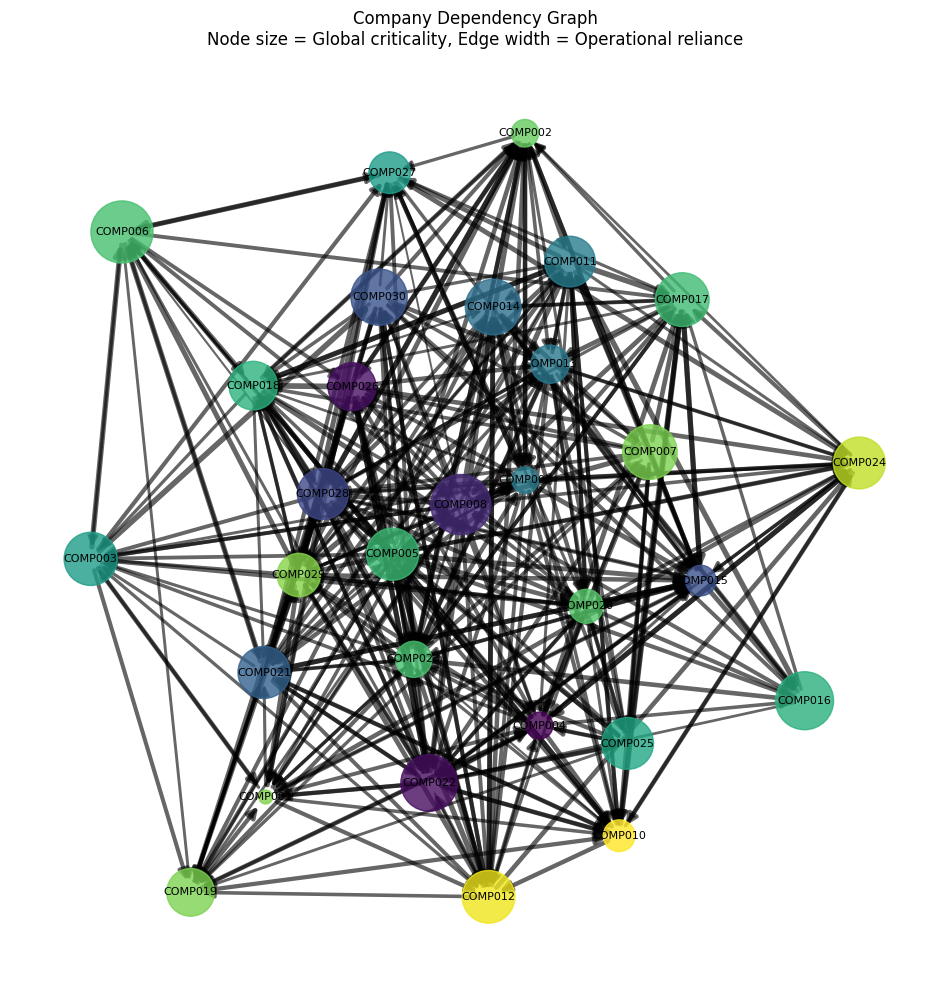

In [19]:
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = GraphAnalyzerCIDM("../data/graph_data.json")

    # 1️⃣ Print graph summary
    analyzer.summary()

    # 2️⃣ Compute recursive systemic influence
    influence_scores = analyzer.systemic_influence()

    # 5️⃣ Optional: visualize network
    analyzer.visualize()


In [20]:
    # Top 10 most systemically critical companies
    print("\nTop 10 most systemically critical companies:")
    top_companies = list(influence_scores.items())[:10]
    for i, (company, score) in enumerate(top_companies, start=1):
        print(f"{i}. {company}: {score:.2f}")

    # 3️⃣ Get detailed info for the top company
    top_company_id = top_companies[0][0]
    print(f"\n=== DETAILED INFO FOR TOP COMPANY: {top_company_id} ===")
    company_info = analyzer.get_company_info(top_company_id, company_file="../data/company_data.json")
    if company_info:
        for key, value in company_info.items():
            print(f"{key}: {value}")

    # 4️⃣ Optional: simulate failure of top company
    affected_companies = analyzer.simulate_failure(top_company_id, threshold=0.3)
    print(f"\nSimulating failure of {top_company_id}...")
    print(f"{len(affected_companies)} companies would be affected:")
    print(affected_companies)




Top 10 most systemically critical companies:
1. COMP015: 62827055019898216897122428627642673512083775029248.00
2. COMP028: 61031504395943777554115978535220160304612496113664.00
3. COMP022: 57458593874237085118872222981988802936802346270720.00
4. COMP012: 57311856004801540460268841221818284400391298744320.00
5. COMP008: 55849681823768030482456759994941181175985023746048.00
6. COMP010: 55506015997206584034285595093098333858940751708160.00
7. COMP002: 52974171390871007482254756344365462783374875688960.00
8. COMP024: 52217069956365545958489500948837758833130471424000.00
9. COMP017: 49003328232505104240335648542349154891193743572992.00
10. COMP023: 48188417430512299604641285421242425394840433852416.00

=== DETAILED INFO FOR TOP COMPANY: COMP015 ===
company_id: COMP015
company_name: Hayden-Ayala
sector_id: 521
sector_name: Monetary Authorities-Central Bank
employee_count: 419
revenue: 563779287.98
market_cap: 1741481691.38
total_assets: 1674786858.88
num_business_clients: 836
num_critical_s

AttributeError: 'GraphAnalyzerCIDM' object has no attribute 'simulate_failure'